##**Evaluate the accuracy, precision, recall and F1 score for your model. Also show a confusion matrix and make predictions of Dataset 2 using Bi-LSTM Model.**

In [55]:
from google.colab import drive;
drive.mount("/content/gdrive");

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## libraires

In [56]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import seaborn as sns;

## load from csv

In [57]:

df = pd.read_csv("/content/gdrive/MyDrive/Colab/Softcomputing/Dataset 2.csv" , encoding = "ISO-8859-1");
print(df.head(5));

                                                text  polarity
0  just had a real good moment. i missssssssss hi...         0
1         is reading manga  http://plurk.com/p/mzp1e         0
2  @comeagainjen http://twitpic.com/2y2lx - http:...         0
3  @lapcat Need to send 'em to my accountant tomo...         0
4      ADD ME ON MYSPACE!!!  myspace.com/LookThunder         0


## total length of csv data

In [58]:
print(len(df));

10314


## emotion count plot

0    8000
1    2314
Name: polarity, dtype: int64
[0.77564475 0.22435525]
[0.2243552452976537, 0.7756447547023463]
['0', '1']
0    8000
1    2314
Name: polarity, dtype: int64


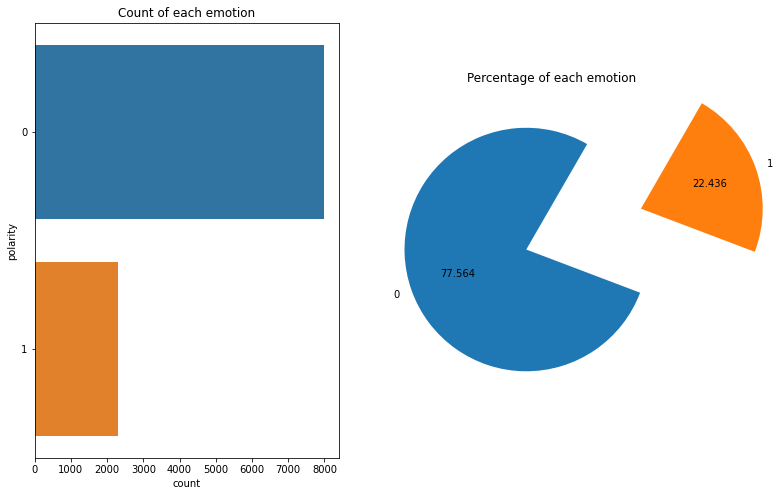

In [95]:
col = 'polarity'

fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
print(df[col].dropna().value_counts());
print((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts()))));
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])
print(explode);
labels = ['0','1'];
print(labels);
sizes = df[col].value_counts()
print(sizes)
#ax1.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%.3f')
ax2.add_artist(plt.Circle((5,5),0.5,fc='black'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

## characters and tokens columns add

In [60]:
df['char_length'] = df['text'].apply(lambda x : len(x))
df['token_length'] = df['text'].apply(lambda x : len(x.split(" ")))
print(df);

                                                    text  ...  token_length
0      just had a real good moment. i missssssssss hi...  ...            12
1             is reading manga  http://plurk.com/p/mzp1e  ...             5
2      @comeagainjen http://twitpic.com/2y2lx - http:...  ...             5
3      @lapcat Need to send 'em to my accountant tomo...  ...            23
4          ADD ME ON MYSPACE!!!  myspace.com/LookThunder  ...             6
...                                                  ...  ...           ...
10309  No Depression by G Herbo is my mood from now o...  ...            20
10310  What do you do when depression succumbs the br...  ...            18
10311  Ketamine Nasal Spray Shows Promise Against Dep...  ...            10
10312  dont mistake a bad day with depression! everyo...  ...            10
10313                                                  0  ...             1

[10314 rows x 4 columns]


## plot number of characters and token

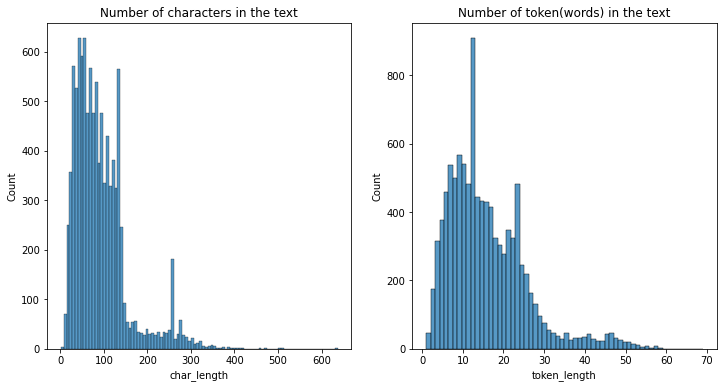

In [61]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.histplot(df['char_length'], ax=ax1)
sns.histplot(df['token_length'], ax=ax2)
ax1.set_title('Number of characters in the text')
ax2.set_title('Number of token(words) in the text')
plt.show()

## preprocessing 

In [62]:
!pip install inflect

## convert didn't to didnot expand words

In [63]:
!pip install contractions

## scraping

In [64]:
!pip install bs4

## preprocessing libs

In [65]:

from sklearn.preprocessing import LabelEncoder;
from sklearn.model_selection import train_test_split;
import nltk;
import inflect;
import contractions;
from bs4 import BeautifulSoup;
import re, string, unicodedata;
from nltk import word_tokenize, sent_tokenize;
from nltk.corpus import stopwords;
from nltk.stem import LancasterStemmer, WordNetLemmatizer;
nltk.download('punkt');
nltk.download('stopwords');
nltk.download('wordnet');

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## preprocessing in process

In [66]:


def text_preprocessing_platform(df, text_col, remove_stopwords=False):
    
    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):

        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser");
        text = soup.get_text();
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text);
        return text;
    
    ## Next step is text-normalization
    
    # Text normalization includes many steps.
    
    # Each function below serves a step.
    
    
    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = [];
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore');
            new_words.append(new_word);
        return new_words;
    
    
    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = [];
        for word in words:
            new_word = word.lower();
            new_words.append(new_word);
        return new_words;
    
    
    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = [];
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word);
            if new_word != '':
                new_words.append(new_word);
        return new_words;
    
    
    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine();
        new_words = [];
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word);
                new_words.append(new_word);
            else:
                new_words.append(word);
        return new_words;
    
    
    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = [];
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word);
        return new_words;
    
    
    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer();
        stems = [];
        for word in words:
            stem = stemmer.stem(word);
            stems.append(stem);
        return stems;
    
    
    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer();
        lemmas = [];
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v');
            lemmas.append(lemma);
        return lemmas;
    
    
    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words);
        words = to_lowercase(words);
        words = remove_punctuation(words);
        words = replace_numbers(words);
        if remove_stopwords:
            words = remove_stopwords(words);
        words = stem_words(words)
        # words = lemmatize_verbs(words);
        return words;
    
    # All above functions work on word tokens we need a tokenizer
    
    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text);
    
    
    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text);
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)]);
        return text;
    
    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]];
    print(text_col)
    
    # return processed df
    return df;

## result of preprocessing

Before Text Preprocessing


,text
0,just had a real good moment. i missssssssss hi...
1,is reading manga http://plurk.com/p/mzp1e
2,@comeagainjen http://twitpic.com/2y2lx - http:...
3,@lapcat Need to send 'em to my accountant tomo...
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder


(10314, 4)
                                                  text  ...  token_length
340  Ever since I bought my Macbook, I send much mo...  ...            21

[1 rows x 4 columns]


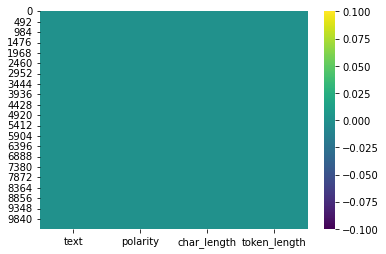

text
After Text Preprocessing


,text
0,real good mom missssssssss much
1,read mang http plurkcompmzp1e
2,comeagaind http twitpiccom2y2lx http wwwyoutub...
3,lapc nee send account tomorrow od ev refer tax...
4,ad myspac myspacecomlookthund


(10314, 4)
                                                  text  ...  token_length
340  ev sint bought macbook send much email fuck ea...  ...            21

[1 rows x 4 columns]


In [67]:
print("Before Text Preprocessing")
display(df.head()[['text']])
print(df.shape);
print(df.loc[[340]])
sns.heatmap(df.isnull(), cmap='viridis')
plt.show()
processed_df = text_preprocessing_platform(df, 'text', remove_stopwords=False)
print("After Text Preprocessing")
display(processed_df.head()[['text']])
print(processed_df.shape);
print(processed_df.loc[[340]]);

processed_df.to_csv('After_cleaning.csv');

## glove download

In [68]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-09-23 06:15:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-09-23 06:15:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-09-23 06:15:16--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [69]:
f = open("glove.6B.50d.txt");

## nn libs


In [70]:
from keras.layers import Dropout, Dense, GRU, Embedding, LSTM, Bidirectional, TimeDistributed, Flatten;
from keras.models import Sequential;
from sklearn.feature_extraction.text import TfidfVectorizer;
from sklearn.metrics import matthews_corrcoef, confusion_matrix;
from sklearn import metrics;
from sklearn.utils import shuffle;
from keras.preprocessing.text import Tokenizer;
from keras.preprocessing.sequence import pad_sequences;
from sklearn.preprocessing import LabelEncoder;

# Logging
import logging;
logging.basicConfig(level=logging.INFO);

import warnings



## tokenization according to gloves ( embedding vecs)

In [71]:
def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    # np.random.seed(7)
    text = np.concatenate((X_train, X_test),axis = 0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open("glove.6B.50d.txt", encoding='ISO-8859-1')
    for line in f:
        try:
            values = line.split()
            word = values[0]
            try:
                coefs = np.asarray(values[1:], dtype='float32')
            except:
                pass
            embeddings_index[word] = coefs
        except UnicodeDecodeError:
            pass
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index, tokenizer)

## model 

In [72]:
def Build_Model_RNN_Text(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    # Model building
    model = Sequential()
    hidden_layer = 3
    lstm_node = 32
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    print(lstm_node)
    for i in range(0,hidden_layer):
        model.add(Bidirectional(LSTM(lstm_node,return_sequences=True, recurrent_dropout=0.5)))
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.5)))
    model.add(Dropout(dropout))
    #model.add(TimeDistributed(Dense(256)))
    #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

## dataset

In [73]:
train_final = processed_df[['text', 'polarity']]
print("Train DataFrame")
display(train_final.head(3))

Train DataFrame


,text,polarity
0,real good mom missssssssss much,0
1,read mang http plurkcompmzp1e,0
2,comeagaind http twitpiccom2y2lx http wwwyoutub...,0


##  label sentimenet (already done no need)

In [74]:

# Label encoding target column
le = LabelEncoder()
train_final['polarity'] = le.fit_transform(train_final['polarity'])

## df for training and prediction
df = train_final

print(df['polarity'])



0        0
1        0
2        0
3        0
4        0
        ..
10309    1
10310    1
10311    1
10312    1
10313    1
Name: polarity, Length: 10314, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## vars

In [75]:
preprocess = True
text = 'text'
target = 'polarity'
MAX_SEQUENCE_LENGTH = 60

## x and y

In [76]:
X = df[text]
y = df[target]

## split

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

## glove vecs


In [78]:
print("Generating Glove Embeddings...")
X_train_Glove,X_test_Glove, word_index,embeddings_index, tokenizer = loadData_Tokenizer(X_train,X_test, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH)

Generating Glove Embeddings...
Found 17933 unique tokens.
(10314, 60)
Total 399955 word vectors.


## training

In [79]:
# Model Training
with warnings.catch_warnings():
    print("Building Model ...")
    model_RNN = Build_Model_RNN_Text(word_index,embeddings_index, 2)
    model_RNN.summary()
    print("\n Starting Training ... \n")
    history = model_RNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=10,
                              batch_size=256,
                              verbose=2)
    warnings.simplefilter("ignore")

Building Model ...
32


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 50)           896700    
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 500, 64)           21248     
_________________________________________________________________
dropout_24 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 500, 64)           24832     
_________________________________________________________________
dropout_25 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 500, 64)           24832     
_________________________________________________________________
dropout_26 (Dropout)         (None, 500, 64)          

29/29 - 84s - loss: 0.5071 - accuracy: 0.7803 - val_loss: 0.3413 - val_accuracy: 0.8662
Epoch 2/10
29/29 - 63s - loss: 0.1932 - accuracy: 0.9331 - val_loss: 0.0957 - val_accuracy: 0.9683
Epoch 3/10
29/29 - 63s - loss: 0.0689 - accuracy: 0.9821 - val_loss: 0.0593 - val_accuracy: 0.9851
Epoch 4/10
29/29 - 63s - loss: 0.0457 - accuracy: 0.9893 - val_loss: 0.0504 - val_accuracy: 0.9877
Epoch 5/10
29/29 - 63s - loss: 0.0404 - accuracy: 0.9904 - val_loss: 0.0467 - val_accuracy: 0.9906
Epoch 6/10
29/29 - 63s - loss: 0.0341 - accuracy: 0.9925 - val_loss: 0.0571 - val_accuracy: 0.9874
Epoch 7/10
29/29 - 63s - loss: 0.0303 - accuracy: 0.9925 - val_loss: 0.0514 - val_accuracy: 0.9906
Epoch 8/10
29/29 - 64s - loss: 0.0255 - accuracy: 0.9942 - val_loss: 0.0513 - val_accuracy: 0.9877
Epoch 9/10
29/29 - 64s - loss: 0.0191 - accuracy: 0.9965 - val_loss: 0.0642 - val_accuracy: 0.9855
Epoch 10/10
29/29 - 64s - loss: 0.0189 - accuracy: 0.9958 - val_loss: 0.0520 - val_accuracy: 0.9906


## graph plot

In [80]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()



 Plotting results ... 



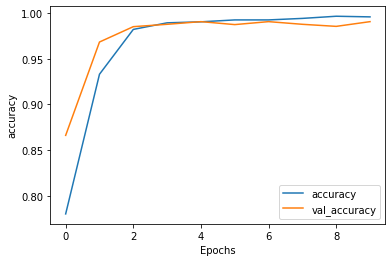

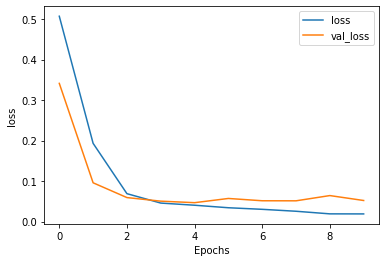

In [81]:
print("\n Plotting results ... \n")
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## predictions and acc

In [82]:
predict_x=model_RNN.predict(X_test_Glove); 
classes_x=np.argmax(predict_x,axis=1)

In [83]:
print(metrics.classification_report(y_test, classes_x));

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2372
           1       0.99      0.97      0.98       723

    accuracy                           0.99      3095
   macro avg       0.99      0.98      0.99      3095
weighted avg       0.99      0.99      0.99      3095



## confusin matrix

In [84]:
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test,classes_x))
cnf_matrix = confusion_matrix(y_test,classes_x);
labels = ['0','1'];
cm1 = pd.DataFrame(cnf_matrix, index = labels, columns = labels)

Confusion Matrix for Decision Tree:
[[2362   10]
 [  19  704]]


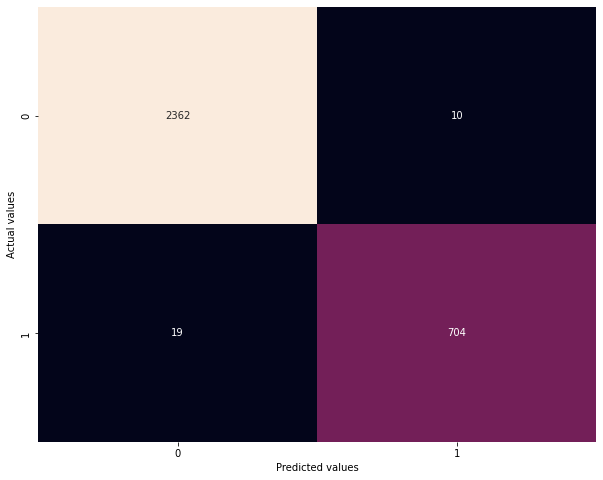

In [88]:
plt.figure(figsize = (10, 8))
sns.heatmap(cm1, annot = True, cbar = False, fmt = 'g')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.show()

## heading baki